# Modelling Excitation Current of Synchrounous Motor Using OLS Regression
In this notebook, we will try to create a simple linear model to predict the excitation current of a Synchrounous Motor.
We will be using the publicly available [Synchronous Machine Data Set Data Set](https://archive.ics.uci.edu/ml/datasets/Synchronous+Machine+Data+Set) from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) and we will recreate this experiment. To know more about our dataset, you may want to read this [paper](https://www.researchgate.net/publication/277307431_Meta-heuristic_linear_modeling_technique_for_estimating_excitation_current_of_synchronous_motor) from [Research Gate](https://researchgate.net).

## Synchronous Motor Setup
To give more background of this dataset, I've included an excerpt from this [paper](https://www.researchgate.net/publication/277307431_Meta-heuristic_linear_modeling_technique_for_estimating_excitation_current_of_synchronous_motor) on how the experiment was setup:

> The scheme of work for the experiment with a SM is shown in Figure 1 [2,4,5]. The excitation current estimation and parameter modeling for a SM in the power factor correction task are realized under operating conditions of Υ /∆ 400 / 231 V, 5.8 / 10 A, cosϕ = 0.8, 4 kVA, 1000 rpm. These parameters are used to prepare the datasets for the AI-based heuristic exploring unit and create the linear and quadratic SM forms.

![experiment setup](./assets/SM.png)

The experimental study procedures are given below:
1. An auxiliary motor is used to drive the SM in the test rig. For this purpose, a serial rheostat is used to obtain a variable DC supply in the field circuit manually.
2. An AC voltage is applied to the stator windings of the SM until the speed of the motor is very close to the synchronous speed.
3. A DC voltage is applied to the field winding of the SM and so synchronous operation is started.
4. After synchronous speed is realized, the field current of the SM is adjusted to its minimum value by means
of a serial rheostat connected in series to the field circuit.

> After step 4, the motor draws minimum current from the supply, the efficiency is maximum, and the
power factor of the SM is at unity. To choose this point as a reference operation condition, the field current is
adjusted by the serial rheostat. Thus, the load and voltage are kept constant. If the field current is increased,
the motor shifts from a unity power factor to leading power factor operation conditions. The experimental tests
are repeated several times under different load conditions. The input and output parameters of the SM are
measured and recorded from the test rig [2–5]. Finally, these parameters are used to create linear and quadratic
SM forms in the heuristic exploring unit.


## Required Software Packages for Analysis
In this experiment, we will be using Python and its scientific libraries to conduct a simple linear regression.

In [1]:
# Arrays and Dataframe abstraction
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Modelling
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression

## Changing Plot Styles
The following code below will simply apply styles from [SciencePlots](https://github.com/garrettj403/SciencePlots) to add aesthetics to our charts.

In [2]:
plt.style.use(["science", "notebook", "scatter"])

## Downloading the Dataset
The following code snippet below will download our dataset from UCI machine learning repositor.

In [3]:
import urllib.request

DATASET_URI = "https://archive.ics.uci.edu/ml/machine-learning-databases/00607/synchronous%20machine.csv"
SAVE_LOCATION = "./assets/dataset.csv"

dl_path, HTTPResult = urllib.request.urlretrieve(DATASET_URI, SAVE_LOCATION)
print(f"Our dataset was succefully downloaded and was saved at {dl_path}")

Our dataset was succefully downloaded and was saved at ./assets/dataset.csv


## Importing and Previewing the Dataset
After downloading our dataset, now we import it and preview its contents. Our dataset is a *comma-separated-value* file with its *decimal number separator* configured as *comma* which can be a problem when loading it in our pandas dataframe. To fix this, we must use the `sep` and `decimal` arguments of `DataFrame.read_csv()` method of pandas. The `sep` will indicate the separator between columns, and `decimal` indicates the separator between whole & decimal numbers.

In [4]:
dataset = pd.read_csv('./assets/dataset.csv', sep=";",decimal=",")
dataset.head()

,Iy,PF,e,dIf,If
0,3.0,0.66,0.34,0.383,1.563
1,3.0,0.68,0.32,0.372,1.552
2,3.0,0.70,0.30,0.360,1.540
3,3.0,0.72,0.28,0.338,1.518
4,3.0,0.74,0.26,0.317,1.497


## Exploratory Analysis
Now let's examine each of our dataset's row. Let's see if they are fit for linear regression. The following code snippet below is a function that can be used to describe each columns of our dataset. It will show the histogram of our data as well as show the QQ plot of our data so that we can visually check if they are normally distributed.

In [5]:
def describe_column(col, data):
  # Create a new Matplotlib figure object and configure it
  fig, ax = plt.subplots(1, 3)
  fig.set_size_inches(16, 8)
  fig.tight_layout(pad=3.0)

  # Create a probability Plot
  order_stat, result = stats.probplot(data[col])

  # Build the Best-fit Line for Probability Plot
  osr_hat = result[1] + result[0]*order_stat[0]

  # Normality Check
  score, p_value = stats.normaltest(data[col])

  # Label the Axes of figure
  ax[0].set_title(f"Box Plot of ${col}$")
  ax[1].set_title(f"Histogram of ${col}$")
  ax[2].set_title(f"Probability Plot of ${col}$")

  # Plot the data each axes
  sns.boxenplot(x=data[col],ax=ax[0])
  sns.histplot(x=data[col], ax=ax[1], stat='density')
  sns.scatterplot(x=order_stat[0], y=order_stat[1], ax=ax[2])
  sns.lineplot(x=order_stat[0], y=osr_hat, ax=ax[2], color='red', label=f"Best Fit $R={result[2]:.2f}$")

  # Show the result of normality test
  print(f"{col} is normaly distributed with p={p_value:.4f}" if p_value <
        0.05 else "f{col} is not normaly distributed with p={p_value:.4f}")


Iy is normaly distributed with p=0.0000


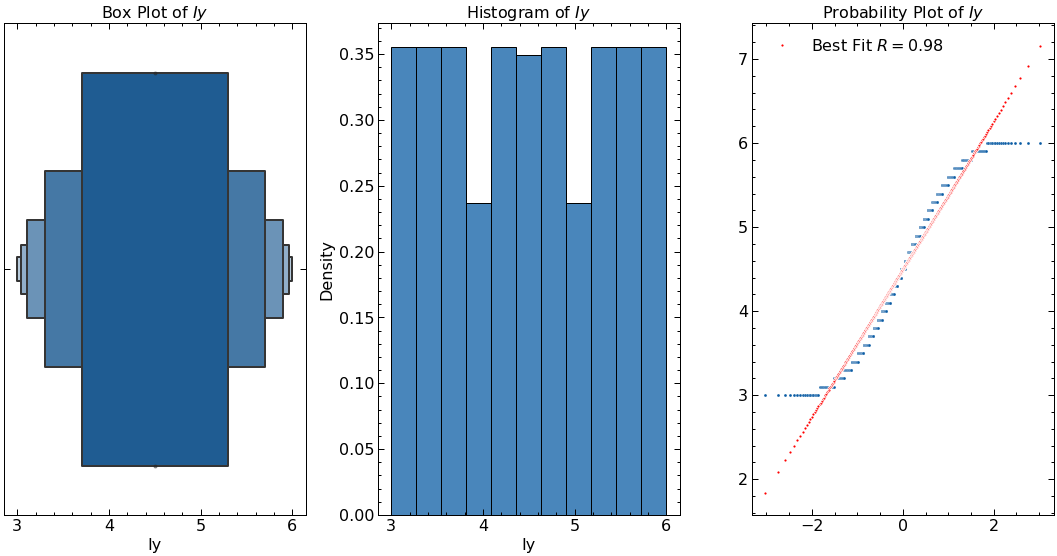

In [6]:
describe_column('Iy',dataset)

PF is normaly distributed with p=0.0000


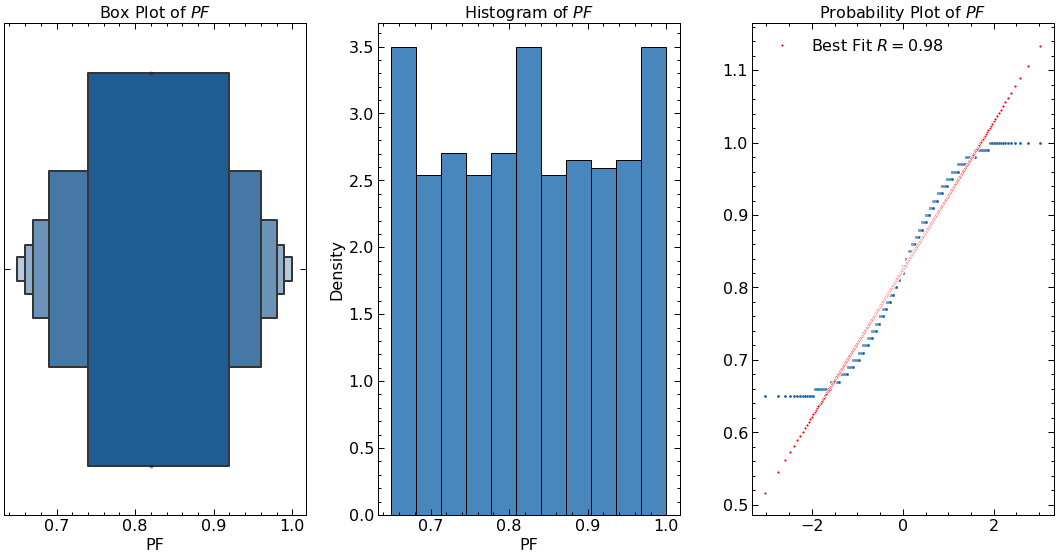

In [7]:
describe_column('PF',dataset)

e is normaly distributed with p=0.0000


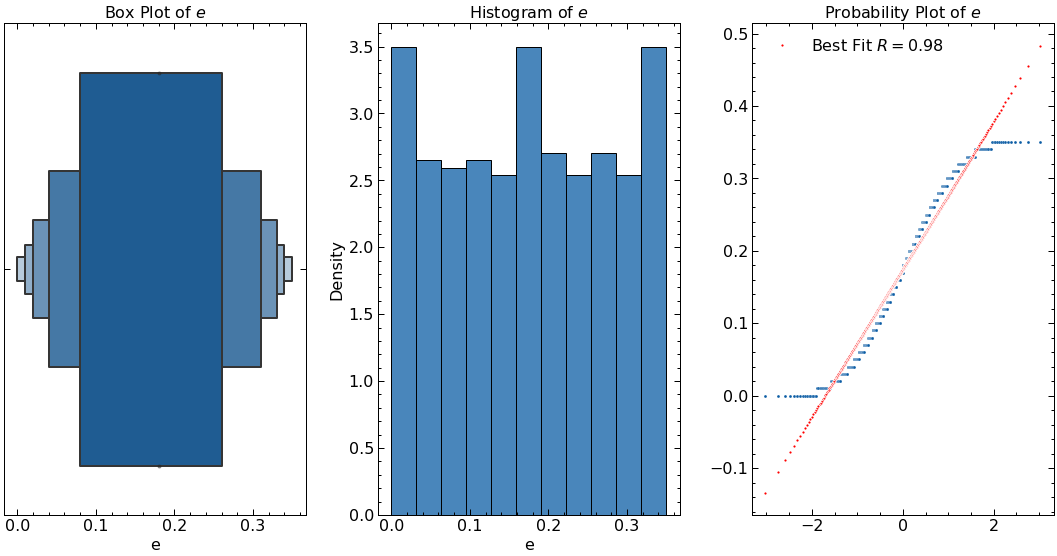

In [8]:
describe_column('e',dataset)

dIf is normaly distributed with p=0.0000


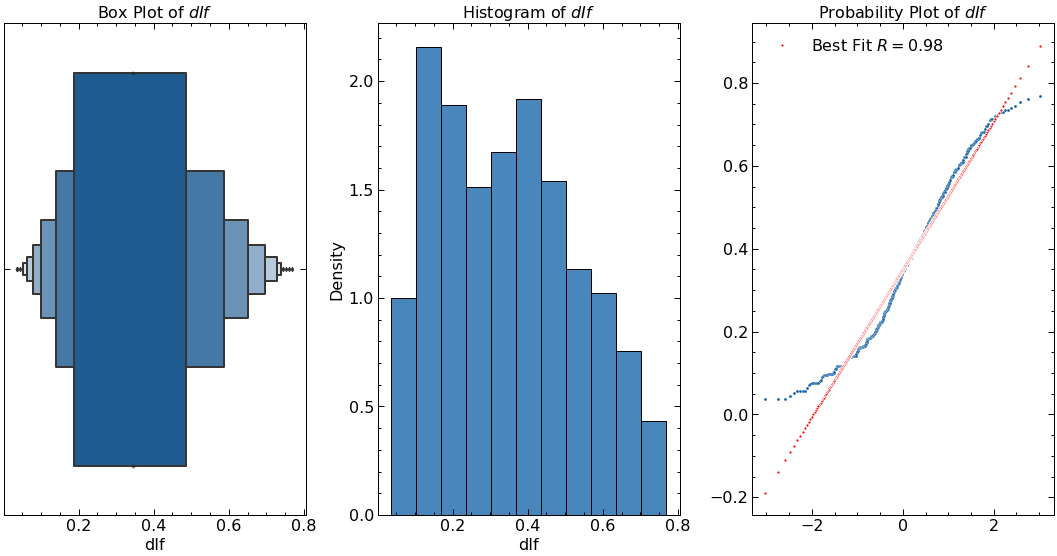

In [9]:
describe_column('dIf',dataset)

If is normaly distributed with p=0.0000


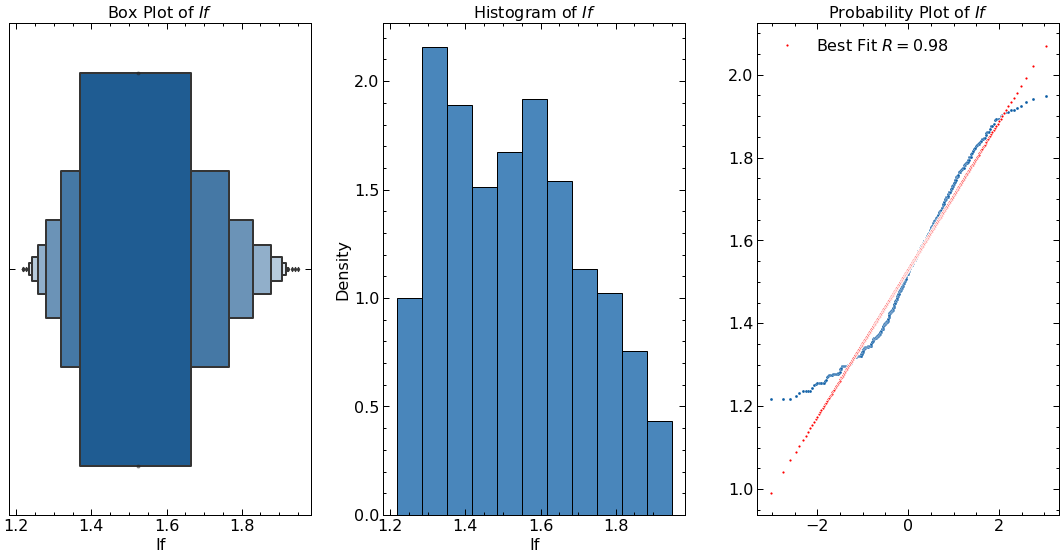

In [10]:
describe_column('If',dataset)

## Correlation Matrix
Now that we have examined the distribution of dataset. This time lets check the correlation of each of our variables from each other. Next we conduct F-regression to see which of our input variable have strong relationship with output variable.

<AxesSubplot:>

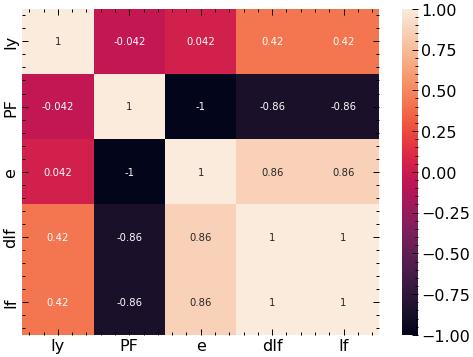

In [11]:
sns.heatmap(dataset.corr(), annot=True)

In [12]:
# Conduct F-Regression
input_col = dataset.columns[:-1]
output_col = dataset.columns[-1]

x = dataset[input_col]
y = dataset[output_col]

F_stat, p_val = f_regression(x,y)
freg_result = pd.DataFrame({
  "Feautures": input_col,
  "F-statistics": F_stat.round(5),
  "P-value": p_val.round(5)
})
freg_result

,Feautures,F-statistics,P-value
0,Iy,1.223068e+02,0.0
1,PF,1.590709e+03,0.0
2,e,1.590709e+03,0.0
3,dIf,1.922691e+17,0.0


> Based on the Result of P-values from F-regression, all 4 features might have a strong relationship with our output variable.

## Regression Analysis
Since our data is normally distributed, we don't need to conduct any transformations to our columns. We can now start our regression analysis.

### Feature Scaling
Before we proceed with regression, it is a good practice to standarized our features so that we can determine the relative impact of each feauture to our linear model.

In [13]:
scaler = StandardScaler()
scaler.fit(x)

x_scaled = scaler.transform(x)

### Conduct Regression
Once the feauteres were standardized, we can now conduct Linear Regression so that we can study our model.

In [14]:
reg = LinearRegression()
reg.fit(x_scaled, y)

LinearRegression()

#### Summarize the Regression Results

Now, our data was fitted to our linear model. Let us now summarize the results.

In [15]:
reg_summary = pd.DataFrame({
  "Feautures": input_col,
  "Intercept": reg.intercept_,
  "Weights": reg.coef_
})
print(f"Coefficient of Determination (R^2): {reg.score(x,y):.2f}")
reg_summary

Coefficient of Determination (R^2): 0.21


,Feautures,Intercept,Weights
0,Iy,1.530659,1.747539e-17
1,PF,1.530659,-2.775558e-17
2,e,1.530659,1.387779e-17
3,dIf,1.530659,1.804038e-01


### Resulting Linear Model
Based on the result of linear regression, our linear model can be described by the following equation below:
$$\widehat{I}_f = 1.5306 + 1.747539x10^{-17}I_y - 2.775558x10^{-17}PF + 1.387779x10^{-17}e + 1.804038x10^{-01}dIf$$

This model has a low coefficient of determination ($R^2=0.21$), thus this linear model, is not yet reliable in predicting excitation current. Based on this model, the only feature that has a strong impact on excitation current $I_f$ is $dIf$ while the other 3 input variables were negligble which is in contradiction from the result of our F-test..